In [25]:
import scanpy as sc
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import glob
from os.path import basename

In [2]:
#read 10x expression data
adata = sc.read_h5ad('GEX_anndata/10k_pbmc.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 9913 × 2000
    obs: 'n_genes', 'doublet_scores', 'predicted_doublets', '_scvi_batch', '_scvi_labels', 'leiden', 'Cell types'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cell types_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/adavydov/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


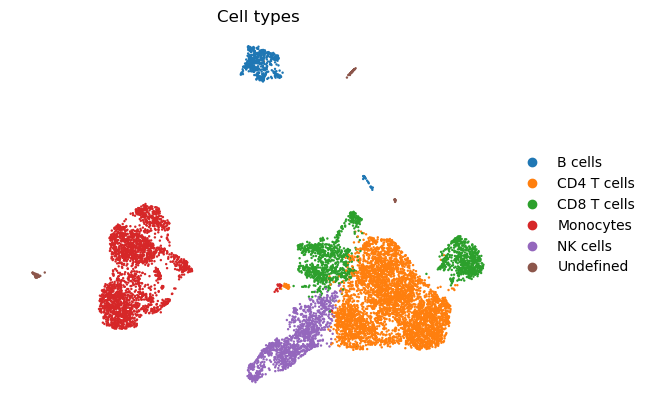

In [4]:
sc.pl.umap(
    adata,
    color=['Cell types'],
    use_raw=True,
    frameon=False,
)

## Performance comparison (figure 2)

In [5]:
#reading MiXCR VDJ data
mixcr_vdj_t = pd.read_table('mixcr_results/10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_t_mixcr.tsv', sep='\t')
mixcr_vdj_b = pd.read_table('mixcr_results/10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_b_mixcr.tsv', sep='\t')
#reading Cell Ranger VDJ data
cr_vdj_b = pd.read_table('cellranger_results/10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_b_cellranger.csv', sep=',')
cr_vdj_t = pd.read_table('cellranger_results/10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_t_cellranger.csv', sep=',')

In [6]:
#label cells that have T/B cell receptor
cr_b_barcodes = cr_vdj_b['barcode'].tolist()
cr_t_barcodes = cr_vdj_t['barcode'].tolist()
mixcr_b_barcodes = mixcr_vdj_b['tagValueCELL'].tolist()
mixcr_t_barcodes = mixcr_vdj_t['tagValueCELL'].tolist()

adata.obs['barcode'] = adata.obs.index
adata.obs['barcode'] = adata.obs['barcode'].apply(lambda x: x.split('-')[0])

cr_b_barcodes = [b.split('-')[0] for b in cr_b_barcodes]
cr_t_barcodes = [b.split('-')[0] for b in cr_t_barcodes]

adata.obs['VDJ B cellranger'] = np.where(adata.obs['barcode'].isin(cr_b_barcodes), 1, 0)
adata.obs['VDJ T cellranger'] = np.where(adata.obs['barcode'].isin(cr_t_barcodes), 1, 0)
adata.obs['VDJ B MiXCR'] = np.where(adata.obs['barcode'].isin(mixcr_b_barcodes), 1, 0)
adata.obs['VDJ T MiXCR'] = np.where(adata.obs['barcode'].isin(mixcr_t_barcodes), 1, 0)

In [7]:
#extract barcodes for cells with paired chains
def paired_cells_cr(df, chain):
    cr_chains = df.groupby('barcode')['chain'].apply(set).reset_index()
    cr_paired_barcodes = []
    for i, row in cr_chains.iterrows():
        chains = row['chain']
        if chain in chains and len(chains)>1:
            cr_paired_barcodes.append(row['barcode'])
        else:
            continue
    return cr_paired_barcodes

def paired_cells_mixcr(df, chain):
    mixcr_chains = df.groupby('tagValueCELL')['topChains'].apply(set).reset_index()
    mixcr_paired_barcodes = []
    for i, row in mixcr_chains.iterrows():
        chains = row['topChains']
        if chain in chains and len(chains)>1:
            mixcr_paired_barcodes.append(row['tagValueCELL'])
        else:
            continue
    return mixcr_paired_barcodes

In [8]:
cr_b_paired_barcodes = paired_cells_cr(cr_vdj_b, 'IGH')
cr_t_paired_barcodes = paired_cells_cr(cr_vdj_t, 'TRB')
mixcr_b_paired_barcodes = paired_cells_mixcr(mixcr_vdj_b, 'IGH')
mixcr_t_paired_barcodes = paired_cells_mixcr(mixcr_vdj_t, 'TRB')

In [9]:
#label cells with paired alpha/beta TCRs or heavy/light IG chains
cr_b_paired_barcodes = [b.split('-')[0] for b in cr_b_paired_barcodes]
cr_t_paired_barcodes = [b.split('-')[0] for b in cr_t_paired_barcodes]
adata.obs['VDJ B cellranger paired'] = np.where(adata.obs['barcode'].isin(cr_b_paired_barcodes), 1, 0)
adata.obs['VDJ T cellranger paired'] = np.where(adata.obs['barcode'].isin(cr_t_paired_barcodes), 1, 0)
adata.obs['VDJ B MiXCR paired'] = np.where(adata.obs['barcode'].isin(mixcr_b_paired_barcodes), 1, 0)
adata.obs['VDJ T MiXCR paired'] = np.where(adata.obs['barcode'].isin(mixcr_t_paired_barcodes), 1, 0)

In [44]:
#Number of cells containing one/pair chains of TCR/IG
cells_df = adata.obs
vdj_stats = cells_df.groupby('Cell types').aggregate({'VDJ B MiXCR' : lambda x: x.sum() / len(x),
                                         'VDJ T MiXCR': lambda x: x.sum() / len(x),
                                        'VDJ B MiXCR paired' : lambda x: x.sum() / len(x),
                                         'VDJ T MiXCR paired': lambda x: x.sum() / len(x),
                                         'VDJ B cellranger' : lambda x: x.sum() / len(x),
                                         'VDJ T cellranger': lambda x: x.sum() / len(x),
                                        'VDJ B cellranger paired' : lambda x: x.sum() / len(x),
                                         'VDJ T cellranger paired': lambda x: x.sum() / len(x)})

In [45]:
vdj_stats

,VDJ B MiXCR,VDJ T MiXCR,VDJ B MiXCR paired,VDJ T MiXCR paired,VDJ B cellranger,VDJ T cellranger,VDJ B cellranger paired,VDJ T cellranger paired
Cell types,,,,,,,,
B cells,0.896887,0.105058,0.854086,0.066148,0.891051,0.075875,0.836576,0.062257
CD4 T cells,0.000000,0.805992,0.000000,0.703310,0.000000,0.761295,0.000000,0.674076
CD8 T cells,0.000655,0.861166,0.000655,0.736084,0.001310,0.811395,0.000655,0.690897
Monocytes,0.002441,0.050448,0.002441,0.039056,0.002441,0.045159,0.002034,0.034988
NK cells,0.000000,0.045260,0.000000,0.019641,0.000000,0.025619,0.000000,0.012810
Undefined,0.000000,0.057692,0.000000,0.048077,0.000000,0.057692,0.000000,0.048077


Text(0, 0.5, 'Fraction of cells with VDJ')

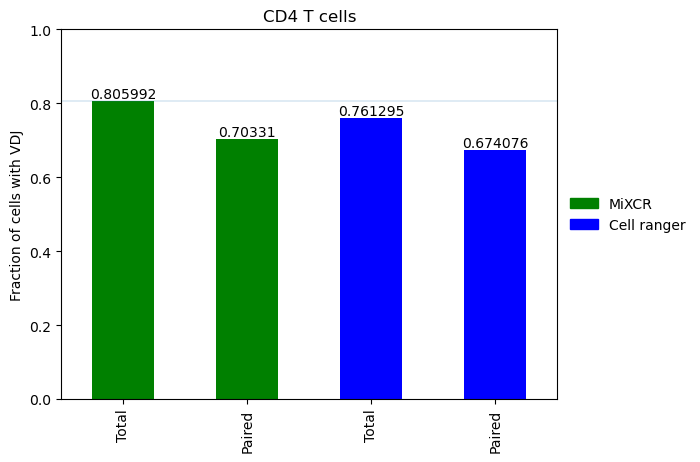

In [46]:
fig, ax = plt.subplots()


vdj_stats_T_CD4 = vdj_stats[['VDJ T MiXCR', 'VDJ T MiXCR paired', 'VDJ T cellranger', 'VDJ T cellranger paired']]
vdj_stats_T_CD4.loc['CD4 T cells'].plot.bar(title = 'CD4 T cells', ax=ax, color = list('ggbb'))
ax.bar_label(ax.containers[0])
ax.set_xticklabels(['Total', 'Paired', 'Total', 'Paired'])
ax.set_ylim(0,1)
green_patch = mpatches.Patch(color='green', label='MiXCR')
blue_patch = mpatches.Patch(color='blue', label='Cell ranger')
plt.legend(handles=[green_patch, blue_patch], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.axhline(y=vdj_stats_T_CD4.loc['CD4 T cells'].max(),linewidth=0.2, linestyle='-')
ax.set_ylabel('Fraction of cells with VDJ')

Text(0, 0.5, 'Fraction of cells with VDJ')

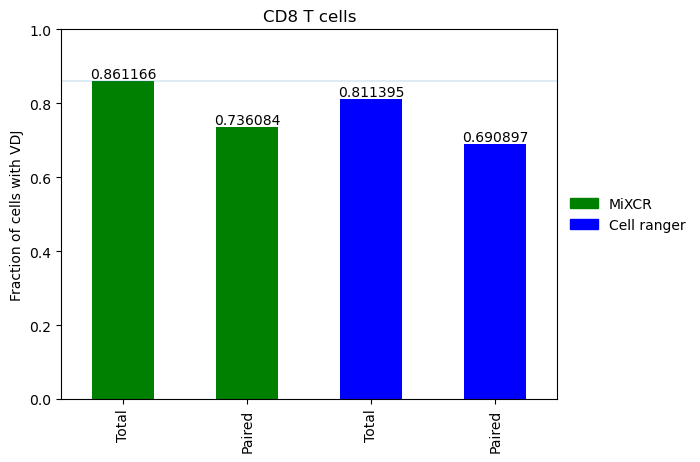

In [47]:
fig, ax = plt.subplots()


vdj_stats_T_CD8 = vdj_stats[['VDJ T MiXCR', 'VDJ T MiXCR paired', 'VDJ T cellranger', 'VDJ T cellranger paired']]
vdj_stats_T_CD8.loc['CD8 T cells'].plot.bar(title = 'CD8 T cells', ax=ax, color = list('ggbb'))
ax.bar_label(ax.containers[0])
ax.set_xticklabels(['Total', 'Paired', 'Total', 'Paired'])
ax.set_ylim(0,1)
green_patch = mpatches.Patch(color='green', label='MiXCR')
blue_patch = mpatches.Patch(color='blue', label='Cell ranger')
plt.legend(handles=[green_patch, blue_patch], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.axhline(y=vdj_stats_T_CD4.loc['CD8 T cells'].max(),linewidth=0.2, linestyle='-')
ax.set_ylabel('Fraction of cells with VDJ')

Text(0, 0.5, 'Fraction of cells with VDJ')

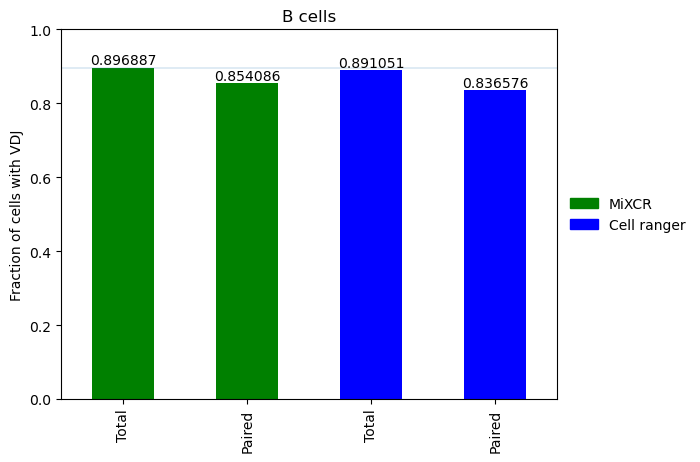

In [48]:
fig, ax = plt.subplots()


vdj_stats_B = vdj_stats[['VDJ B MiXCR', 'VDJ B MiXCR paired', 'VDJ B cellranger', 'VDJ B cellranger paired']]
vdj_stats_B.loc['B cells'].plot.bar(title = 'B cells', ax=ax, color = list('ggbb'))
ax.bar_label(ax.containers[0])
ax.set_xticklabels(['Total', 'Paired', 'Total', 'Paired'])
ax.set_ylim(0,1)
green_patch = mpatches.Patch(color='green', label='MiXCR')
blue_patch = mpatches.Patch(color='blue', label='Cell ranger')
plt.legend(handles=[green_patch, blue_patch], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.axhline(y=vdj_stats_B.loc['B cells'].max(),linewidth=0.2, linestyle='-')
ax.set_ylabel('Fraction of cells with VDJ')

# Cells/clones overlap analyses (figure 1)

In [15]:
from matplotlib_venn import venn2, venn2_circles

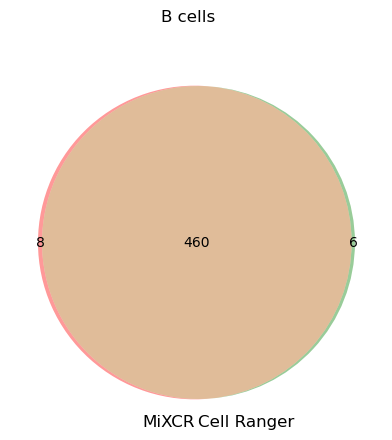

In [16]:
vdj_T_mixcr_barcodes = adata.obs[adata.obs['VDJ T MiXCR']==1]['barcode'].tolist()
vdj_B_mixcr_barcodes = adata.obs[adata.obs['VDJ B MiXCR']==1]['barcode'].tolist()
vdj_T_cr_barcodes = adata.obs[adata.obs['VDJ T cellranger']==1]['barcode'].tolist()
vdj_B_cr_barcodes = adata.obs[adata.obs['VDJ B cellranger']==1]['barcode'].tolist()
venn2([set(vdj_B_mixcr_barcodes), set(vdj_B_cr_barcodes)], ('MiXCR', 'Cell Ranger'), )
plt.gcf().suptitle("B cells");

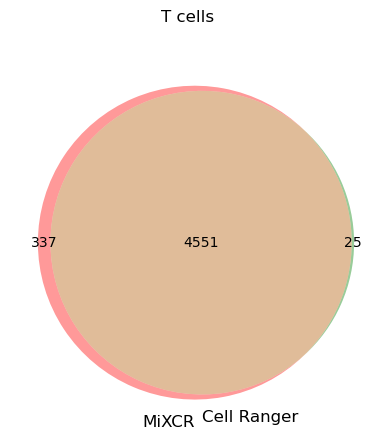

In [17]:
venn2([set(vdj_T_mixcr_barcodes), set(vdj_T_cr_barcodes)], ('MiXCR', 'Cell Ranger'), )
plt.gcf().suptitle("T cells");

In [18]:
#create columns with nt or aa VDJ sequences
mixcr_vdj_t['ntVDJ'] = mixcr_vdj_t['nSeqFR1']+mixcr_vdj_t['nSeqCDR1']+mixcr_vdj_t['nSeqFR2']+mixcr_vdj_t['nSeqCDR2']+mixcr_vdj_t['nSeqFR3']+mixcr_vdj_t['nSeqCDR3']+mixcr_vdj_t['nSeqFR4']
mixcr_vdj_b['ntVDJ'] = mixcr_vdj_b['nSeqFR1']+mixcr_vdj_b['nSeqCDR1']+mixcr_vdj_b['nSeqFR2']+mixcr_vdj_b['nSeqCDR2']+mixcr_vdj_b['nSeqFR3']+mixcr_vdj_b['nSeqCDR3']+mixcr_vdj_b['nSeqFR4']
mixcr_vdj_t['aaVDJ_part'] = mixcr_vdj_t['aaSeqFR1']+mixcr_vdj_t['aaSeqCDR1']+mixcr_vdj_t['aaSeqFR2']+mixcr_vdj_t['aaSeqCDR2']+mixcr_vdj_t['aaSeqFR3']+mixcr_vdj_t['aaSeqCDR3']
mixcr_vdj_b['aaVDJ_part'] = mixcr_vdj_b['aaSeqFR1']+mixcr_vdj_b['aaSeqCDR1']+mixcr_vdj_b['aaSeqFR2']+mixcr_vdj_b['aaSeqCDR2']+mixcr_vdj_b['aaSeqFR3']+mixcr_vdj_b['aaSeqCDR3']

cr_vdj_t['ntVDJ'] = cr_vdj_t['fwr1_nt'] + cr_vdj_t['cdr1_nt'] + cr_vdj_t['fwr2_nt'] + cr_vdj_t['cdr2_nt'] + cr_vdj_t['fwr3_nt'] + cr_vdj_t['cdr3_nt'] + cr_vdj_t['fwr4_nt']
cr_vdj_t['aaVDJ'] = cr_vdj_t['fwr1'] + cr_vdj_t['cdr1'] + cr_vdj_t['fwr2'] + cr_vdj_t['cdr2'] + cr_vdj_t['fwr3'] + cr_vdj_t['cdr3'] + cr_vdj_t['fwr4']
cr_vdj_b['ntVDJ'] = cr_vdj_b['fwr1_nt'] + cr_vdj_b['cdr1_nt'] + cr_vdj_b['fwr2_nt'] + cr_vdj_b['cdr2_nt'] + cr_vdj_b['fwr3_nt'] + cr_vdj_b['cdr3_nt'] + cr_vdj_b['fwr4_nt']
cr_vdj_b['aaVDJ'] = cr_vdj_b['fwr1'] + cr_vdj_b['cdr1'] + cr_vdj_b['fwr2'] + cr_vdj_b['cdr2'] + cr_vdj_b['fwr3'] + cr_vdj_b['cdr3'] + cr_vdj_b['fwr4']

In [19]:
#filtering clones (remove non productive)
mixcr_vdj_t['VDJ_len'] = mixcr_vdj_t['ntVDJ'].str.len()
mixcr_vdj_t = mixcr_vdj_t[mixcr_vdj_t['VDJ_len']>=250]
mixcr_vdj_b['VDJ_len'] = mixcr_vdj_b['ntVDJ'].str.len()
mixcr_vdj_b = mixcr_vdj_b[mixcr_vdj_b['VDJ_len']>=250]

mixcr_vdj_b = mixcr_vdj_b[~mixcr_vdj_b['aaVDJ_part'].str.contains('\*')]
mixcr_vdj_b = mixcr_vdj_b[~mixcr_vdj_b['aaVDJ_part'].str.contains('_')]

mixcr_vdj_t = mixcr_vdj_t[~mixcr_vdj_t['aaVDJ_part'].str.contains('\*')]
mixcr_vdj_t = mixcr_vdj_t[~mixcr_vdj_t['aaVDJ_part'].str.contains('_')]

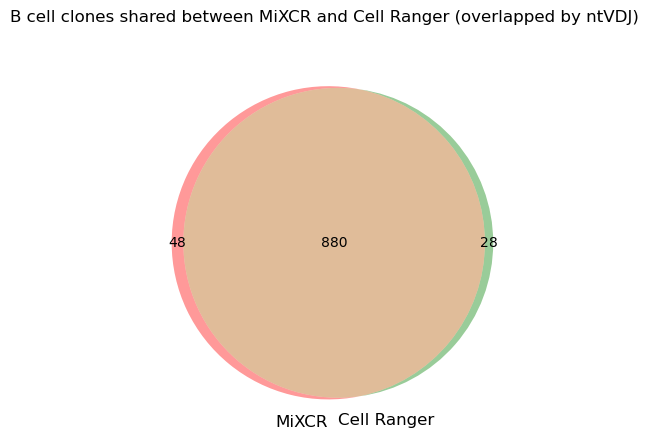

In [20]:
cr_list = cr_vdj_b['ntVDJ'].tolist()
mixcr_list = mixcr_vdj_b['ntVDJ'].tolist()
venn2([set(mixcr_list), set(cr_list)], ('MiXCR', 'Cell Ranger'), )
plt.gcf().suptitle("B cell clones shared between MiXCR and Cell Ranger (overlapped by ntVDJ)");

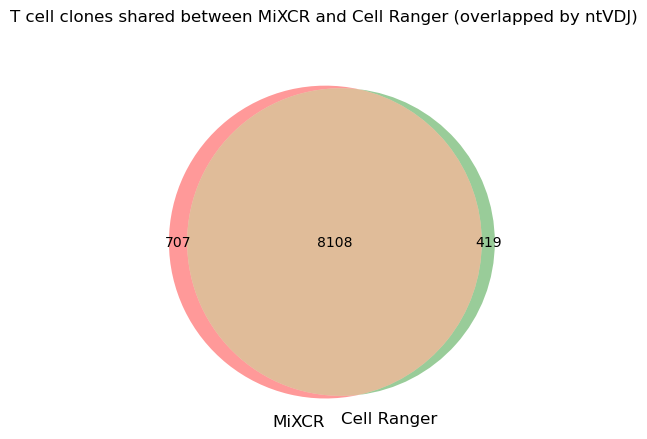

In [21]:
cr_list = cr_vdj_t['ntVDJ'].tolist()
mixcr_list = mixcr_vdj_t['ntVDJ'].tolist()
venn2([set(mixcr_list), set(cr_list)], ('MiXCR', 'Cell Ranger'), )
plt.gcf().suptitle("T cell clones shared between MiXCR and Cell Ranger (overlapped by ntVDJ)");

## Dependence on sequencing depth (figure 3)

In [32]:
MiXCR_RESULT_PATH_TCELLS = 'downsampled_data/T_cells/mixcr'
MiXCR_RESULT_PATH_BCELLS = 'downsampled_data/B_cells/mixcr'
CR_RESULT_PATH_TCELLS = 'downsampled_data/T_cells/cellranger'
CR_RESULT_PATH_BCELLS = 'downsampled_data/B_cells/cellranger'

In [38]:
def process_data(path):
    stats_list = []
    software = path.split('/')[-1]
    cell_type = path.split('/')[-2]
    if software == 'mixcr':
        delimeter = '\t'
        ext = '.tsv'
        barcode_column = 'tagValueCELL'
        chain_column = 'topChains'
    else:
        barcode_column = 'barcode'
        chain_column = 'chain'
        delimeter = ','
        ext = '.csv'
    if cell_type == 'T_cells':
        chain = 'TRB'
        file_prefix = '10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_t' 
    else:
        chain = 'IGH'
        file_prefix = '10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_b'
    for files in glob.glob(path+f'/{file_prefix}_1_d*{ext}'):
        perc = basename(files).split('.')[0].split('_')[-1]
        if perc.endswith('pct'):
            pct = int(perc[1:-3])
        elif perc[1] == '0':
            pct = int(perc[2:])*10
        else:
            pct = int(perc[1:])*10
        table = pd.read_table(files, sep=delimeter)
        grouped_table = table.groupby(barcode_column)[chain_column].apply(set).reset_index()
        paired_cells = []
        for index, row in grouped_table.iterrows():
            chains = row[chain_column]
            if chain in chains and len(chains)>1:
                paired_cells.append(row[barcode_column])
        stats_list.append([pct, len(grouped_table), len(paired_cells)])
        stats_df = pd.DataFrame(stats_list, columns=['Downsampled to, %', 'Number of cells', 'Number of paired cells'])
        stats_df.sort_values('Downsampled to, %', ascending=False, inplace=True, ignore_index=True)
    return stats_df

In [39]:
stat_table_mixcr_t = process_data(MiXCR_RESULT_PATH_TCELLS)
stat_table_mixcr_b = process_data(MiXCR_RESULT_PATH_BCELLS)
stat_table_cr_t = process_data(CR_RESULT_PATH_TCELLS)
stat_table_cr_b = process_data(CR_RESULT_PATH_BCELLS)

In [40]:
stat_table_mixcr_b

,"Downsampled to, %",Number of cells,Number of paired cells
0,100,471,448
1,90,470,441
2,80,470,441
3,70,470,442
4,60,471,430
5,50,467,428
6,40,470,416
7,30,465,404
8,20,459,360
9,10,447,243


In [41]:
stat_table_cr_b

,"Downsampled to, %",Number of cells,Number of paired cells
0,100,470,438
1,90,468,436
2,80,465,432
3,70,462,431
4,60,466,421
5,50,463,420
6,40,454,399
7,30,443,390
8,20,419,338
9,10,286,220


In [42]:
stat_table_mixcr_t

,"Downsampled to, %",Number of cells,Number of paired cells
0,100,4902,4209
1,90,4880,4209
2,80,4859,4205
3,70,4837,4214
4,60,4799,4198
5,50,4761,4175
6,40,4727,4153
7,30,4686,4115
8,20,4624,4050
9,10,4560,3841


In [43]:
stat_table_cr_t

,"Downsampled to, %",Number of cells,Number of paired cells
0,100,4579,3983
1,90,4579,3974
2,80,4579,3970
3,70,4565,3955
4,60,4564,3954
5,50,4555,3933
6,40,4550,3924
7,30,4531,3878
8,20,4500,3787
9,10,4392,3460
